In [ ]:
# in this notebook we compute the variance explained
# by the linear sparce PCA and the SDP sparce pca
# in a various datasets.

In [ ]:
# to compute the variance explained, we follow the paper
#"https://www.sciencedirect.com/science/article/pii/S0169743919303636"

In [1]:
using RDatasets
using Pkg
using NBInclude
using MultivariateStats
#@nbinclude("RandomGraphs.ipynb")
#@nbinclude("MaxCutRelaxations.ipynb")
using NBInclude
using StatsBase
using Arpack
using NBInclude
using DelimitedFiles
using LightGraphs
using JuMP 
using Mosek
using NBInclude
using Pkg
using LinearAlgebra
using MosekTools
using Statistics
using Random
using Distributions
using Plots
using BenchmarkTools
 using DataFrames

In [2]:
function SdpSparsePCA(A,k)
    n = size(A)[1]
    m = Model(Mosek.Optimizer)
    set_silent(m)
      @variable(m,X[1:n,1:n],PSD ) 
      @constraint(m,tr(X)==1)
    
      @variable(m,Y[1:n,1:n],Symmetric)  
          @constraint(m,Y.>=X )
           @constraint(m,Y.>=-X )
           @constraint(m,sum(Y)<=k)
       @objective(m,Max,tr(A*X))
      status = optimize!(m)
     return([value.(X),value.(Y),objective_value(m),solve_time(m)])
end      

#function to compute the linear relaxation of the semidefinite relaxation of sparse PCA of the matrix A
#with target sparcity k.
#@param: A the matrix to compute the sparse PCA
#@param: k, the target sparcity.
function EigenRelSparsePCA(A,k)
    n = size(A)[1]
    m = Model(Mosek.Optimizer)
    set_silent(m)
      @variable(m,-1<=X[1:n,1:n]<=1,Symmetric ) 
      @constraint(m,tr(X)==1)
      @variable(m,Y[1:n,1:n],Symmetric)  
          @constraint(m,Y.>=X )
           @constraint(m,Y.>=-X )
           @constraint(m,sum(Y)<=k)
    
    
      eigenFacto =  eigen(A)
    eigenVectors = eigenFacto.vectors
    rounded = round.(eigenFacto.vectors,digits=3)
    cons = rounded.*100
      
       
      for i in 1:n
        @constraint(m,X[i,i]>=0)
               v =  cons[:,i]
              @constraint(m,transpose(v)*X*v >=0)
     #   println(i)
     #   println(sum(v))
        end  
    
       @objective(m,Max,tr(A*X))
      status = optimize!(m)
     return([value.(X),value.(Y),objective_value(m),solve_time(m)])
end      





EigenRelSparsePCA (generic function with 1 method)

In [3]:
#function to compute the variance explained by sparse PCAs
# k is a vector where k[i] is the target sparcity of pc i. Length of k is the number of PCs

#data is the data set to be used
#@returns the variance explained by the SDP and the variance explained by the LP.
function computeVarianceSDP(k,data,normalize::Bool)
#currentCovMatrix = cor(data)    
  n = size(data)[1]   
    
  if normalize == true
    
    currentCovMatrix = (1/(n-1))* scattermat(data) 
        
    else
        currentCovMatrix = scattermat(data) 
    end    
    
    dims = size(currentCovMatrix)[1]
     
numPc = length(k)   
#sdp 
  SdpSol=SdpSparsePCA(currentCovMatrix,k[1])[1]
currentPc =eigen(SdpSol).vectors[:,dims]
PCs = currentPc  
 currentCovMatrix = currentCovMatrix-(transpose(currentPc)*currentCovMatrix*currentPc)*currentPc*transpose(currentPc)
 for i in 2:numPc
     
SdpSol=SdpSparsePCA(currentCovMatrix,k[i])[1]        
currentPc =eigen(SdpSol).vectors[:,dims] 
PCs = hcat(PCs,currentPc) 
    
currentCovMatrix = currentCovMatrix-(transpose(currentPc)*currentCovMatrix*currentPc)*currentPc*transpose(currentPc)    
    end
    
PCs= round.(PCs,digits=4)
 That = data*PCs*pinv(transpose(PCs)*PCs) 
    
   # return(That)
VarianceExplained = tr(PCs*transpose(That)*That*transpose(PCs))/tr(data*transpose(data))
   
 return(VarianceExplained)   
end

computeVarianceSDP (generic function with 1 method)

In [4]:
#function to compute the variance explained by sparse PCAs
# k is a vector where k[i] is the target sparcity of pc i. Length of k is the number of PCs

#data is the data set to be used
#@returns the variance explained by the SDP and the variance explained by the LP.
# data is assumed to be centered
function computeVarianceLP(k,data,normalize::Bool)
#currentCovMatrix = cor(data)
 n = size(data)[1]   
 
    if normalize == true
    
    currentCovMatrix = (1/(n-1))* scattermat(data) 
        
    else
        currentCovMatrix = scattermat(data) 
    end
        
dims = size(currentCovMatrix)[1]
numPc = length(k)   
#sdp 
  SdpSol=EigenRelSparsePCA(currentCovMatrix,k[1])[1]
currentPc =eigen(SdpSol).vectors[:,dims]
PCs = currentPc
 
 currentCovMatrix = currentCovMatrix-(transpose(currentPc)*currentCovMatrix*currentPc)*currentPc*transpose(currentPc)
 for i in 2:numPc
     
SdpSol=EigenRelSparsePCA(currentCovMatrix,k[i])[1]        
currentPc =eigen(SdpSol).vectors[:,dims] 
PCs = hcat(PCs,currentPc) 
    
currentCovMatrix = currentCovMatrix-(transpose(currentPc)*currentCovMatrix*currentPc)*currentPc*transpose(currentPc)    
    end
    
PCs= round.(PCs,digits=4)
 That = data*PCs*pinv(transpose(PCs)*PCs) 
    
   # return(That)
VarianceExplained = tr(PCs*transpose(That)*That*transpose(PCs))/tr(data*transpose(data))
   
 return(VarianceExplained)   
end

computeVarianceLP (generic function with 1 method)

In [23]:
# fucntion to curate the datasets we will use. 


function processDataset(min_number_covariates,max_number_covariates)
    
    datas =  RDatasets.datasets()
    num_data_tables = size(datas)[1]
    datas[!,:num_float_vars]= zeros(size(datas)[1])

      
for i in 1:  num_data_tables
        
     currentTable = dataset(datas[i,1], datas[i,2])
     currentTable = select(currentTable, findall(col -> eltype(col) <: Float64, eachcol(currentTable)))
      datas[i,size(datas)[2]]= size(currentTable)[2]   
     end
    
  datas =  datas[datas.num_float_vars .> min_number_covariates, :]
   datas = datas[datas.num_float_vars .<=max_number_covariates,:]

    
    return(datas)
end



processDataset (generic function with 1 method)

In [50]:
# function to give the value of the variance explained, fixing
# the same vectors for both methods

function give_variances(datasetName::String,tableName::String,sparcityPatern,normalize::Bool)
   
    num_Pcs = length(sparcityPatern) 
    
    dat = dataset(datasetName, tableName)
    dat = select(dat, findall(col -> eltype(col) <: Float64, eachcol(dat)))
    dat =Matrix(dat)    
    
    #Careful, for the pca, observations must be in columns. For our methods, our observations
    # are in rows. Also, the fit function regularizes the matrix by default
    
    # normalize the data
    dat = mapslices(x -> x.-mean(x), dat, dims=1)
    
    dat_for_normal_PCA = transpose(dat)
    totalVarExplainedPCA = principalratio(fit(PCA,iris2Reg,maxoutdim=num_Pcs)) 
     return( computeVarianceLP(sparcityPatern,dat,normalize),  computeVarianceSDP(sparcityPatern,dat),totalVarExplainedPCA)
end


#function to return the best variance explained found by altering the sparcity target. 
function findBestKoneComponent(datasetName::String,tableName::String,normalize::Bool)
   
    dat = dataset(datasetName, tableName)
    dat = select(dat, findall(col -> eltype(col) <: Float64, eachcol(dat)))
    dat =Matrix(dat)
    dat = mapslices(x -> x.-mean(x), dat, dims=1)

    numVars = size(dat)[2]
    max_sparcity = Int64(floor(numVars/2))+1
    bestLP = 0
    bestSDP = 0
    
    #compute the pca explained variance
    
    
    dat_for_normal_PCA = transpose(dat)
    totalVarExplainedPCA = principalratio(fit(PCA,dat_for_normal_PCA,maxoutdim=1)) 
    
    
      for i in 1:max_sparcity
        bestLP = max(bestLP, computeVarianceLP([i],dat,normalize))
        bestSDP =  max(bestSDP, computeVarianceSDP([i],dat,normalize))
    end
    return(bestLP,bestSDP,totalVarExplainedPCA)
end



#function to plot the best variance explained against different datasets
# we take p datasets of the RDatasets, with at least 10 variables.
function plot_explained_variances()
    
    # first select the datasets to run our methods. We select datasets
    # that after selecting 
    datas =  RDatasets.datasets()
datas =  datas[datas.Columns .> 15, :]
datas = datas[datas.Columns.<=20,:]
    
    
    
    plot(scatter(xpepe,xticks=(1:3,labelsx)))
    
end


 

plot_explained_variances (generic function with 1 method)

<h1>Computation of variance explained on different datasets<h1>

In [ ]:
# first an example using the Iris dataset

<h3>Iris dataset<h3>

In [41]:
irisRaw = dataset("datasets", "iris")
iris = select(irisRaw, findall(col -> eltype(col) <: Float64, eachcol(irisRaw)))
iris =Matrix(iris)

150×4 Matrix{Float64}:
 5.1  3.5  1.4  0.2
 4.9  3.0  1.4  0.2
 4.7  3.2  1.3  0.2
 4.6  3.1  1.5  0.2
 5.0  3.6  1.4  0.2
 5.4  3.9  1.7  0.4
 4.6  3.4  1.4  0.3
 5.0  3.4  1.5  0.2
 4.4  2.9  1.4  0.2
 4.9  3.1  1.5  0.1
 5.4  3.7  1.5  0.2
 4.8  3.4  1.6  0.2
 4.8  3.0  1.4  0.1
 ⋮              
 6.0  3.0  4.8  1.8
 6.9  3.1  5.4  2.1
 6.7  3.1  5.6  2.4
 6.9  3.1  5.1  2.3
 5.8  2.7  5.1  1.9
 6.8  3.2  5.9  2.3
 6.7  3.3  5.7  2.5
 6.7  3.0  5.2  2.3
 6.3  2.5  5.0  1.9
 6.5  3.0  5.2  2.0
 6.2  3.4  5.4  2.3
 5.9  3.0  5.1  1.8

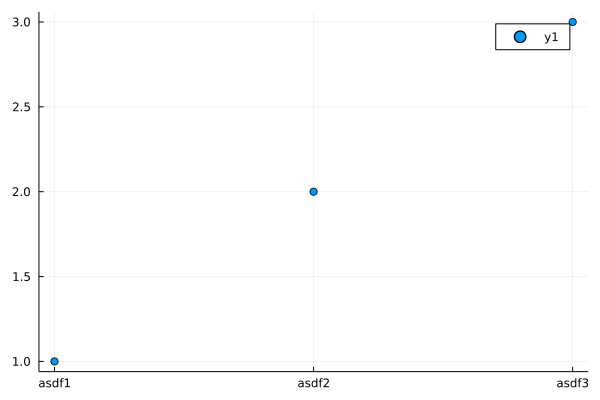

In [10]:
#xpepe = [ 1, 2, 3]
#labelsx = ["asdf1","asdf2","asdf3" ]
#plot(scatter(xpepe,xticks=(1:3,labelsx)))

In [72]:
 results = give_variances("datasets","iris",[2,2],true)

(0.9217920792666314, 0.9373067405651081)

<h2>Now we compute the variance explained of the selected datasets<h2>

In [ ]:
# first select the datasets to use. We want between 8 and 20 float64 covariates.
datasets_to_use = processDataset(8,20)

In [ ]:
# Because of lack of memory problem, we run the method to find variance outside a function

number_tables, number_cols= size(datasets_to_use)
computed_variances = zeros(number_tables,3)

 for i in 1: number_tables
    println(i)
   computed_variances[i,:] .=  findBestKoneComponent(String(datasets_to_use[i,1]),String(datasets_to_use[i,2]),false)
    end 



In [58]:

#function to plot the best variance explained against different datasets
# we take p datasets of the RDatasets, with at least 10 variables.
# param dataSet dataset containing the names of tables to be used to computes variance explained
# by the pca, SDP sparce plca and LP sparce PCA.
# We assume dataSet was selected using the processDataset function.
function explained_variances(dataSet::Any)
    
    number_tables, number_cols= size(dataSet)
    
    computed_variances = zeros(number_tables,3)
    
     
    for i in 1: number_tables
 
   computed_variances[i,:] .=  findBestKoneComponent(String(dataSet[i,1]),String(dataSet[i,2]),false)
    end 
   return(computed_variances)  

end


 

explained_variances (generic function with 1 method)

In [ ]:
variances_results = explained_variances(datasets_to_use)